<a href="https://colab.research.google.com/github/mannixp/PDF_Equation/blob/main/Diffusion/Diffusion_1D_Stochastic_BCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook applies the forward Kolmogorov equation derived in *Craske J. et al. 2024* to the case of 1D scalar diffusion with boundary conditions prescribed by an Ornstein-Ulhenbeck process. The diffusion equation is solved using finite-differences, while the relevant terms in the forward Kolmogorov equation are estimated using histograms.


**Content**

First let's import everything we need to run the rest of the notebook.

In [18]:
from   scipy import sparse
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

**Problem Equations**

The scalar concentration is given by
\begin{equation}
\frac{d Y}{dt} = \partial^2_X Y_t, \quad X \in [0,1],
\end{equation}
subject to the boundary conditions prescribed by the stochastic differential equation
\begin{equation}
 dY_t = -a Y_t dt + \sigma dW_t , \quad \text{at} \quad X = 0,1, \\
\end{equation}
where $a,\sigma$ are drift and diffusion coefficients respectively and $W_t$ the Wiener process which evolves independently on each boundary. The steady state solution to the Fokker-Planck equation corresponding to this SDE is given by the normal distribution $\mathcal{N}(0,\frac{\sigma^2}{2a})$. As such this zero mean process is completely characterised by its variance $\sigma^2/2a$ and auto-correlation $\rho(s) = e^{-|s|/T_L}$ such that $T_L = \int_0^{\infty} \rho(s) ds$ is equivalent to the integral time-scale of this process.

Below we write a solver for the SDE as well as for the 1D diffusion problem.

In [19]:
def OU(Y_t,W_t,dt, μ_z,a,σ):
  
  """
  Ornstein-Ulhenbeck process
  """

  dW_t = np.sqrt(dt) * W_t

  # Euler Maruyama
  return  Y_t + a*(μ_z - Y_t)*dt + σ * dW_t

def Derivatives(N,dx):

  def Grad(N):
    Akp1 =  np.ones(N-1)
    Akm1 = -np.ones(N-1)
    return sparse.diags( [Akm1,Akp1], [-1,1] )/2

  def Laplacian(N, bcs = 'Dirichlet'):
    Akp1 = np.ones(N-1)
    Ak0  = -2*np.ones(N)
    Akm1 = np.ones(N-1)

    if bcs == 'Neumann':
        Akp1[0 ] = 2.0; # Use f_1     = f_-1    @ f_0
        Akm1[-1] = 2.0; # Use f_{N+1} = f_{N-1} @ f_N
    elif bcs == 'Dirichlet':
        Akp1[0]  = 0.
        Ak0[0]   = 0.; Ak0[-1] =0.
        Akm1[-1] = 0.

    return sparse.diags( [Akm1,Ak0,Akp1], [-1,0,1] )

  D = Grad(N)/dx
  L = Laplacian(N)/dx**2

  return D, L

def Solve(Nt=10**4,T=10,Nz=64,a=5,σ=1,W=None):

  # Domain
  z, Δz = np.linspace(0,1,Nz,retstep=True)
  t, Δt = np.linspace(0,T,Nt,retstep=True)

  # Derivatives
  D, L = Derivatives(Nz,Δz)
  I = sparse.eye(L.shape[0],format="csr")
  A = sparse.csr_matrix(I/Δt - L/2)
  B = sparse.csr_matrix(I/Δt + L/2)

  # Noise
  if W is None:
    W = ss.norm.rvs(loc=0, scale=1, size=(Nt,2))

  # Initial conditions
  Y = np.zeros((Nt,Nz))
  Yz = np.zeros((Nt,Nz))
    
  # Solve
  for n,t_i in enumerate(t[:-1]):

    # Interior according to heat diffusion
    Y[n+1,:]  = sparse.linalg.spsolve(A,B.dot(Y[n,:]))

    # BCs according to OU process
    Y[n+1, 0] = OU(Y_t=Y[n, 0], W_t=W[n,0], dt=Δt, μ_z=0, a=a, σ=σ)
    Y[n+1,-1] = OU(Y_t=Y[n,-1], W_t=W[n,1], dt=Δt, μ_z=0, a=a, σ=σ)

    # Grab the gradient
    Yz[n+1,:] = D.dot(Y[n+1,:])

  return t,z,Y,Yz

Setting $a=5,\sigma=1$ we use the solvers to generate a space time plot of the concentration field starting from $Y_0 = 0$ which for vanishing variance $\sigma$ would be the analytical solution to this problem. Note that $a,\sigma$ can be chnaged to investigate different solution regimes.

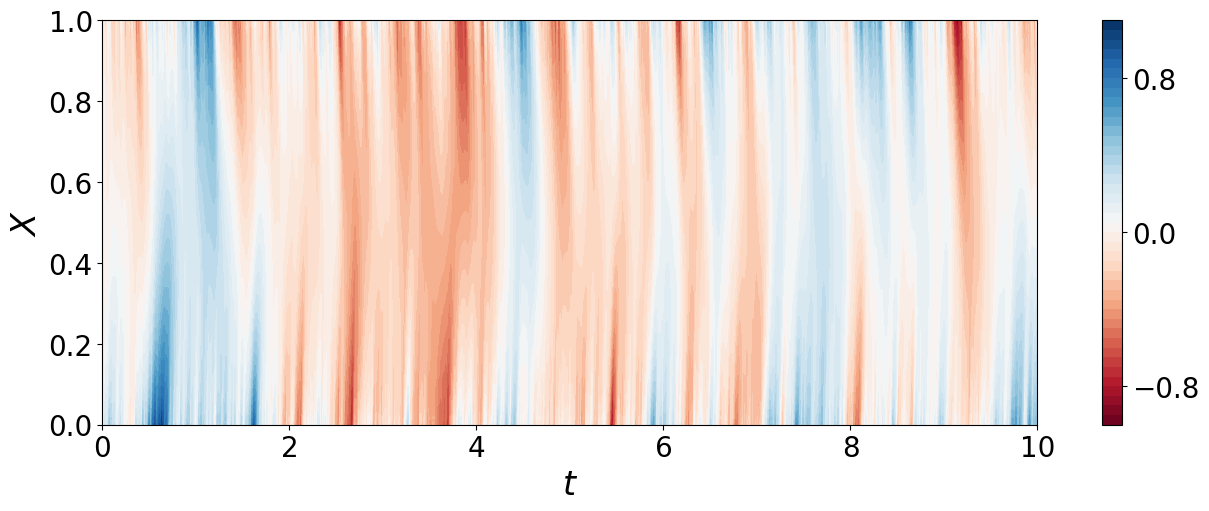

In [20]:
t_vec, z_vec, Y_vec,_ = Solve(Nt=10**4,T=10,Nz=64,a=5,σ=1)

from matplotlib import ticker

fig = plt.figure(figsize=(12,5),layout='constrained')
plt.contourf(t_vec,z_vec,Y_vec.T,levels=50,cmap='RdBu')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20) 
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()

plt.xlabel(r'$t$',fontsize=24)
plt.ylabel(r'$X$',fontsize=24)
plt.tick_params(axis='both', labelsize=20)
plt.show()

The forward Kolmogorov equation describing the *global scalar concentration* is given by
\begin{equation}
\frac{\partial }{ \partial t} f_Y = -\frac{\partial}{ \partial y} \left( \mathbf{D}^{(1)} f_Y \right) + \frac{\partial^2 }{ \partial y^2} \left( \mathbf{D}^{(2)} f_Y \right),
\end{equation}
where
\begin{equation}
\mathbf{D}^{(1)} = 2 \mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ] \frac{f_{Y|\partial \Omega }}{f_Y}, \quad\quad \mathbf{D}^{(2)} = \mathbb{E}_{Y_t}[-|\nabla Y_t|^2].
\end{equation}
Here $f_{Y|\partial\Omega}$ corresponds to the density of $Y_t$ when it is sampled from the boundary $\partial \Omega$ while $f_Y(y;t)$ is the global probability density . This density describes the probability of finding a scalar concentration $y$ at a time $t$ in the interval $X \in [0,1]$. Given however that we are forcing the system by a stationary stochastic process we expect both $f_Y$ and $f_{Y|\partial\Omega}$ to be independent of time.

As our system is stochastic we must employ a Monte-Carlo approach in order to estimate the terms in this equation. That is we must time integrate the diffusion problem with different realisations of the Ornstein-Ulhenbeck process, and then average over the ensemble of sample paths generated by each run. This is performed below by integrating 250 realisations from $t=0 \to 10$. 


*Note: This takes about 2-3 minutes to run*

In [28]:
# Here we choose a smaller resolution as compared
# with the published manuscript due to the limited
# resolution provided by cocalc
Nz=48
T=10
Nt=10**4
Paths=250

pad = 50
stp = (Nt-pad,Paths)
Y0_Data = np.zeros(stp)
Y1_Data = np.zeros(stp)
Y0zData = np.zeros(stp)
Y1zData = np.zeros(stp)

stzp = (Nt-pad,Nz,Paths)
Y_data   = np.zeros(stzp)
dY2_data = np.zeros(stzp)

W  = ss.norm.rvs(loc=0, scale=1, size=(Nt,2,Paths))

for n in range(Paths):

    t,z,Y_n,Yz_n=Solve(Nt,T,Nz)

    # Correct for the end points using:
    dz = z[1] - z[0]
    Yz_n[pad:, 0] = (Y_n[pad:, 1] - Y_n[pad:, 0])/dz # forward differences 
    Yz_n[pad:,-1] = (Y_n[pad:,-1] - Y_n[pad:,-2])/dz # backward differences 
    
    # z-integrated
    Y_data[:,:,n]  =   Y_n[pad:,:] # time,z_data
    dY2_data[:,:,n]=  Yz_n[pad:,:]**2

    # Boundaries
    Y0_Data[:,n] = Y_n[pad:, 0] # time,z=0
    Y1_Data[:,n] = Y_n[pad:,-1]
    Y0zData[:,n] = Yz_n[pad:, 0]
    Y1zData[:,n] = Yz_n[pad:,-1]

    if n%(Paths//5) == 0:
        print('Completed %d/%d paths of the ensemble \n'%(n,Paths))

Completed 0/250 paths of the ensemble 

Completed 50/250 paths of the ensemble 

Completed 100/250 paths of the ensemble 

Completed 150/250 paths of the ensemble 

Completed 200/250 paths of the ensemble 



*Density*

Using a histogram we first estimate the pdf $f_Y(y)$ by binning over time and the ensemble of realisations. Given therefore that $f_Y(y;t)$ is stationary its time-derivative is not estimated. 

In [29]:
def density(Y_data,Range,N_bins):

  f,y = np.histogram(Y_data[...].flatten(),range=Range,bins=N_bins,density=True); 
  y   = 0.5*(y[1:] + y[:-1]);

  return f,y

*Diffusion Coefficient*

We then compute the diffusion coefficient
\begin{equation}
\mathbf{D}^{(2)} \equiv \mathbb{E}_{Y}[-|\nabla Y_t|^2] = - \int \phi \frac{ f_{\Phi Y }(\phi,y) }{f_Y(y)} d \phi, \quad \text{where} \quad \Phi = |\nabla Y|^2,
\end{equation}
by using the fact that the conditional expectation can be re-expressed in terms of its joint density. This coefficent is calculated below by estimating the joint density using a histogram by binning over time and the ensemble of realisations.

In [30]:
def diffusion(dY2_data,Y_data,Range,N_bins):

  # Expectation
  # Let Φ = |∇Y|^2 and φ its dummy variable

  Y   = Y_data[...].flatten()
  dY2 = dY2_data[...].flatten()

  f_YΦ,y,φ = np.histogram2d(Y,dY2,range = (Range,(min(dY2),max(dY2))),bins=N_bins,density=True)
  φ = .5*(φ[1:]+φ[:-1]); dφ = φ[1] - φ[0];
  y = .5*(y[1:]+y[:-1]); dy = y[1] - y[0];
  f_Y =  np.sum(  f_YΦ,axis=1)*dφ;      # f_Y(y)
  E   = (np.sum(φ*f_YΦ,axis=1)*dφ)/f_Y; # E{Φ|Y} = int_φ f_Φ|Y(φ|y)*φ dφ
  D2  = -E

  return D2

*Drift coefficient*

Finally we calculate the drift coefficient by using the fact that the product of the density $f_{Y|\partial \Omega }$ and the conditional average of the gradient of $Y_t$ restricted to the boundary $\mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ]$ can be expressed as
\begin{equation}
\mathbf{D}^{(1)} = 2\mathbb{E}_{Y_t|\partial \Omega}[ \boldsymbol{n} \cdot \nabla Y_t ] f_{Y|\partial \Omega } = 2 \int \phi f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\phi, y) d\phi. 
\end{equation}
We calculate this term by estimating the joint density $f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\phi, y)$ using a histogram (by binning over time and the ensemble of realisations) which can then be used to compute the previous integral as implemented below.

In [31]:
nz_minus = -1 # at z=0
nz_plus  =  1 # at z=1

def Expectation(Y,dY,y,N_bins):
    
    f_YΦ,_,φ = np.histogram2d(Y,dY,range = ((min(y),max(y)),(min(dY),max(dY))),bins=N_bins,density=True) # n (-3)
    φ   = .5*(φ[1:]+φ[:-1]); 
    dφ  = φ[1] - φ[0];
    E   = np.sum(φ*f_YΦ,axis=1)*dφ # E{Φ|Y=y}*f(y) = int_φ f_ΦY(φ,y)*φ dφ where φ = n.∇Y_t

    return E

def drift(f,y, Y0,Y1,Yz0,Yz1,N_bins):

  Y_t   = np.hstack( ( Y1[...].flatten(),   Y0[...].flatten())  )
  nDY_t = np.hstack( (nz_plus*Yz1[...].flatten(), nz_minus*Yz0[...].flatten())  )
  return 2*Expectation(Y_t,nDY_t,y,N_bins)/f

**Results**

We first generate the joint PDF $f_{\boldsymbol{n} \cdot \nabla Y_t,Y|\partial \Omega}(\phi, y)$ by averaging over realisations and time. 

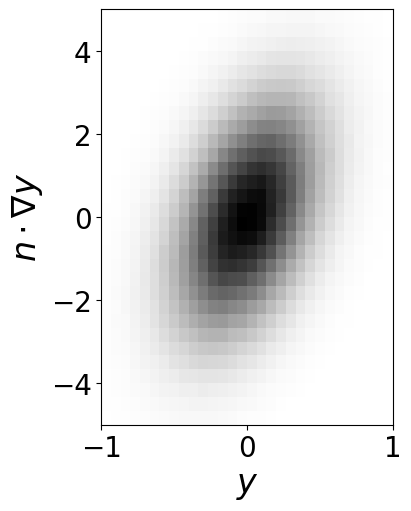

In [32]:
fig = plt.figure(figsize=(4,5),layout='constrained')

Y_DATA = np.concatenate((Y0_Data[...].flatten(),Y1_Data[...].flatten()))
dY_DATA= np.concatenate((nz_minus*Y0zData[...].flatten(),nz_plus*Y1zData[...].flatten()))

plt.hist2d(x=Y0_Data[...].flatten(), y=nz_minus*Y0zData[...].flatten(),range = ((-1,1),(-5,5)),bins = 30, cmap='binary')
plt.xlabel(r'$y$',fontsize=24)
plt.ylabel(r'$n \cdot \nabla y$',fontsize=24)

plt.tick_params(axis='both', labelsize=20)
plt.show()

Using the previous functions we then generate the density, drift and diffusion coefficients $f_Y, \mathbf{D}^{(1)}, \mathbf{D}^{(2)}$ from the ensemble of realisations. These are plotted below along with a comparison of the terms in the right hand side of the foward Kolmogorov equation. We restrict the range of the figure's axes as outliers have a low probability and are thus difficult to converge. Increasing the number of bins improves the agreement between the drift $\mathbf{D}^{(1)}f_Y$ and diffusion $\partial_y (\mathbf{D}^{(2)}f_Y)$ terms, but this also increases the variance it their trends. For this reason we have applied a Gaussian filter to the data in frame (c) when making this comparison. 

In [33]:
def Plot_Terms(y,f,D1,D2):

  fig, axs = plt.subplots(2, 2, layout='constrained',figsize=(12,6))

  # ~~~~~~~~~ (a) ~~~~~~~
  axs[0,0].plot(y,D1,'k', linewidth=2,label=r'$\mathbf{D}^{(1)}(y)$')

  # ~~~~~~~~~ (b) ~~~~~~~
  axs[0,1].plot(y,D2,'k', linewidth=2,label=r'$\mathbf{D}^{(2)}(y)$')

  # ~~~~~~~~~ (c) ~~~~~~~

  N = len(y)
  D = np.zeros((N,N))
  for i in range(N):
    
    if i < N - 1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1 
  
  D*=.5/(y[1]-y[0])

  from scipy.ndimage import gaussian_filter1d

  axs[1,0].plot(y,D@(gaussian_filter1d(D2*f,sigma=2)),'b--', linewidth=2,label=r'$\partial_y \left( \mathbf{D}^{(2)} f_Y \right)$')
  axs[1,0].plot(y,gaussian_filter1d(D1*f,sigma=2),'r-', linewidth=2,label=r'$\mathbf{D}^{(1)} f_Y$')

  axs[1,0].set_xlabel(r'$y$',fontsize=20)

  # ~~~~~~~~~ (d) ~~~~~~~
  axs[1,1].plot(y,f,'r', linewidth=2,label=r'$f_Y(y)$')
  axs[1,1].fill_between(x=y,y1=f,color= "r",alpha= 0.2)
  axs[1,1].set_ylim([0,1.1*max(f)])

  axs[1,1].set_xlabel(r'$y$',fontsize=20)

  axs[0,0].annotate(r'(a)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)
  axs[0,1].annotate(r'(b)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)
  axs[1,0].annotate(r'(c)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)
  axs[1,1].annotate(r'(d)', xy=(0.05,0.85), xycoords='axes fraction',fontsize=24)

  for ax in [axs[0,0],axs[1,0],axs[0,1],axs[1,1]]:
    ax.set_xlim([min(y),max(y)])
    ax.legend(loc=8,fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

  axs[1,0].legend(loc=4,fontsize=20)

  plt.savefig('1D_Diffusion.png',dpi=200)
  plt.show()

  return None;

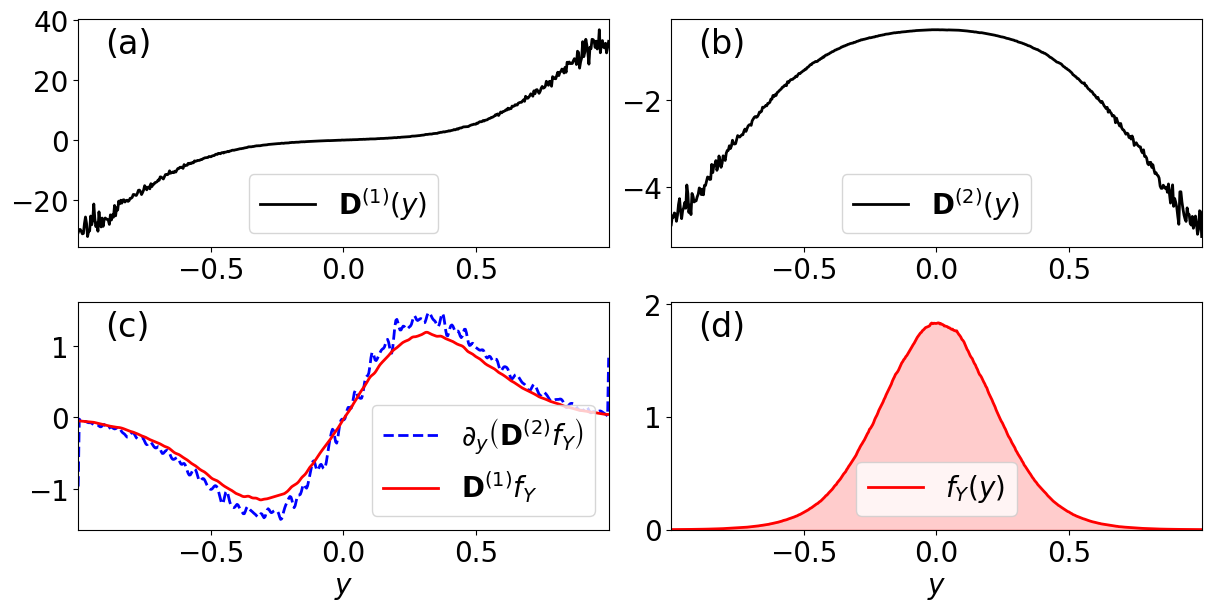

In [34]:

Range = (-1,1)
N_bins=512

# Estimate the terms
f,y = density(Y_data,Range,N_bins)
D2  = diffusion(dY2_data,Y_data,Range,N_bins)
D1  = drift(f,y, Y0_Data,Y1_Data,Y0zData,Y1zData, N_bins)

Plot_Terms(y,f,D1,D2)